In [1]:
import numpy as np
import pandas as pd
import glob,imp,os
from pandas.io.json import json_normalize
import pyslha
import matplotlib as mpl
import matplotlib.tri as tri
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.interpolate import griddata

In [2]:
smodelsFolder = '../data/IDM/2sigma_smallDetaM_xsecs/'
slhaFolder = '../data/IDM/2sigma_smallDetaM_xsecs/'

In [3]:
#Convert Experimental Results list to a dictionary
data = []
for f in glob.glob(smodelsFolder+'/*.py'):
    smodelsDict = imp.load_source(f.replace('.py',''),f).smodelsOutput 
    if 'ExptRes' in smodelsDict:
        expList = sorted(smodelsDict['ExptRes'], key=lambda pt: pt['r'],reverse=True)
        expDict = dict([['result%i'%i,val] for i,val in enumerate(expList)])
        smodelsDict['ExptRes'] = expDict
    smodelsDict.pop("Asymmetric Branches")
    smodelsDict.pop("Long Cascades")
    smodelsDict.pop("Outside Grid")
    smodelsDict.pop("Missed Topologies")
    slhaFile = smodelsDict['OutputStatus']['input file']
    dataDict = {'filename' : os.path.basename(slhaFile)}
    dataDict.update(smodelsDict)
    data.append(dataDict)

In [4]:
#Convert data to flat DataFrame:
smodelsDF = json_normalize(data)
smodelsDF = smodelsDF.set_index('filename', drop=True)
#Select only points which have constraints:
smodelsDF = smodelsDF.loc[~np.isnan(smodelsDF['ExptRes.result0.r'])]

In [5]:
#Get SLHA data:
slhaData = []
for f in smodelsDF.index.values:
    slhaFile = os.path.join(slhaFolder,f)
    slha = pyslha.readSLHAFile(slhaFile)
    massDict = dict([[str(key),val] for key,val in slha.blocks['MASS'].items() if key > 25])
    widthDict = dict([[str(key),val.totalwidth] for key,val in slha.decays.items() if key > 25])
    slhaDict = {'filename' : f, 'mass' : massDict, 'width' : widthDict}
    slhaData.append(slhaDict)

In [6]:
#Convert to DataFrame
slhaDF = json_normalize(slhaData)
slhaDF = slhaDF.set_index('filename', drop=True)

In [7]:
#Merge with SModelS DataFrame
dataDF = slhaDF.merge(smodelsDF,left_index=True,right_index=True)

In [8]:
#Define relevant subsets
excludedDF = dataDF[dataDF['ExptRes.result0.r'] > 1.]

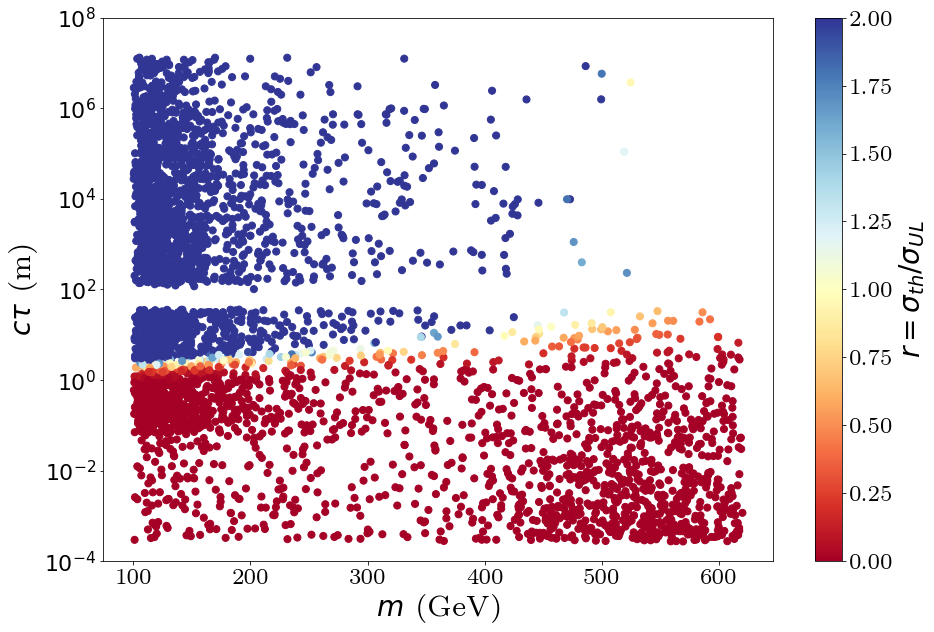

In [14]:
from commonRCparameters import params
mpl.rcParams.update(params)
mHc = dataDF['mass.37']
ctau = 1.967e-16/dataDF['width.37']
r = dataDF['ExptRes.result0.r']
cm = plt.cm.get_cmap('RdYlBu')
x,y,z = mHc,ctau,r
# # Plot scatter plot (for double checking the results)
cp = plt.scatter(x,y, c=z, vmin=0., vmax=2., s=50, cmap=cm)
cb = plt.colorbar(cp)
plt.yscale('log')
plt.xlabel(r'$m$ (GeV)')    
plt.ylabel(r'$c\tau$ (m)')
cb.set_label(r'$r=\sigma_{th}/\sigma_{UL}$')
plt.ylim(1e-4,1e8)
# plt.xlim(80,300)
plt.savefig('IDM_points_r.png')
plt.show()

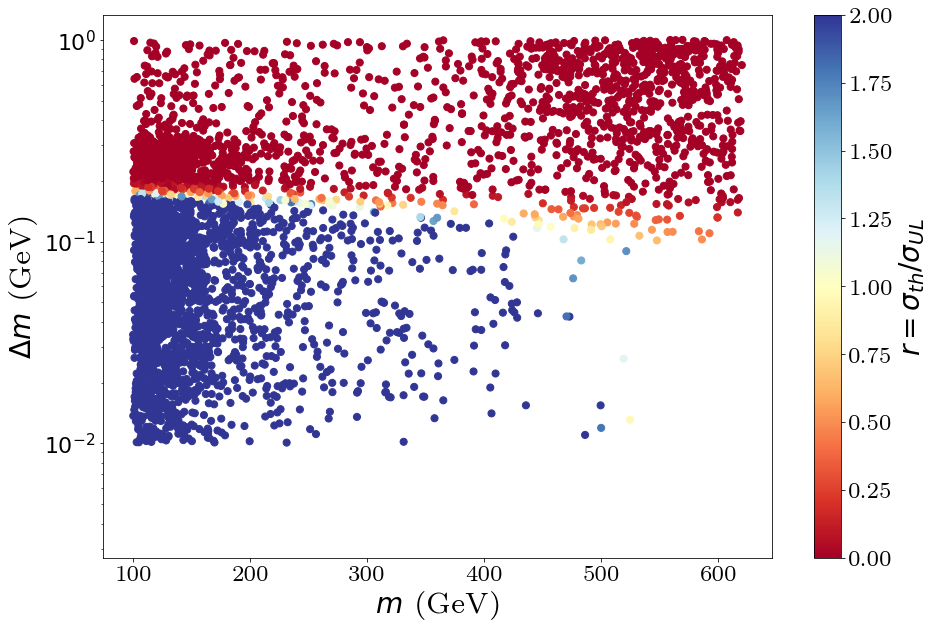

In [17]:
deltaM = (dataDF['mass.37']-dataDF['mass.35'])
mHc = dataDF['mass.37']
r = dataDF['ExptRes.result0.r']
cm = plt.cm.get_cmap('RdYlBu')
x,y,z = mHc,deltaM,r
# # Plot scatter plot (for double checking the results)
cp = plt.scatter(x,y, c=z, vmin=0., vmax=2., s=50, cmap=cm)
cb = plt.colorbar(cp)
plt.yscale('log')
plt.xlabel(r'$m$ (GeV)')    
plt.ylabel(r'$\Delta m$ (GeV)')
cb.set_label(r'$r=\sigma_{th}/\sigma_{UL}$')
# plt.ylim(1e-4,1e8)
# plt.xlim(80,300)
plt.savefig('IDM_points_deltaM.png')
plt.show()

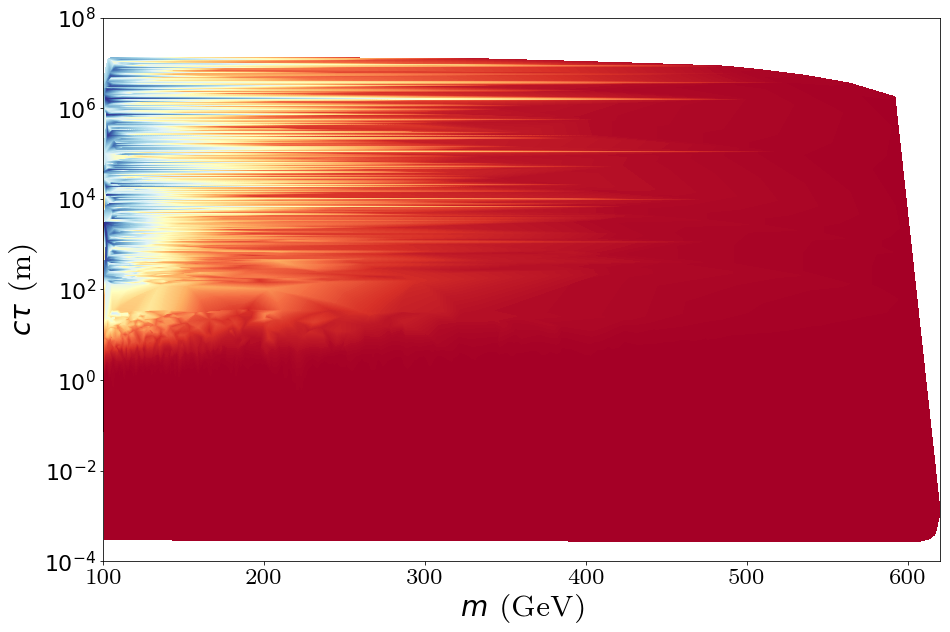

In [20]:
from commonRCparameters import params
mpl.rcParams.update(params)
cm = plt.cm.get_cmap('RdYlBu')
x,y,z = mHc,ctau,r

# # Create the Triangulation; no triangles so Delaunay triangulation created.
triang = tri.Triangulation(x,y)
cp = plt.tricontourf(triang, z,cmap=cm, levels=np.arange(0.,120.,0.5))
# cs = plt.tricontour(triang, z, colors='k',levels=[0.8,1.0,1.2])
# plt.clabel(cs, cs.levels, inline=True, fontsize=25, fmt='%1.1f')
# cb = plt.colorbar(cp)
plt.yscale('log')
plt.xlabel(r'$m$ (GeV)')    
plt.ylabel(r'$c\tau$ (m)')
# cb.set_label(r'$r=\sigma_{th}/\sigma_{UL}$')
plt.ylim(1e-4,1e8)
# # plt.xlim(50.,800.)
# # plt.savefig('gbPlot.pdf')
plt.show()

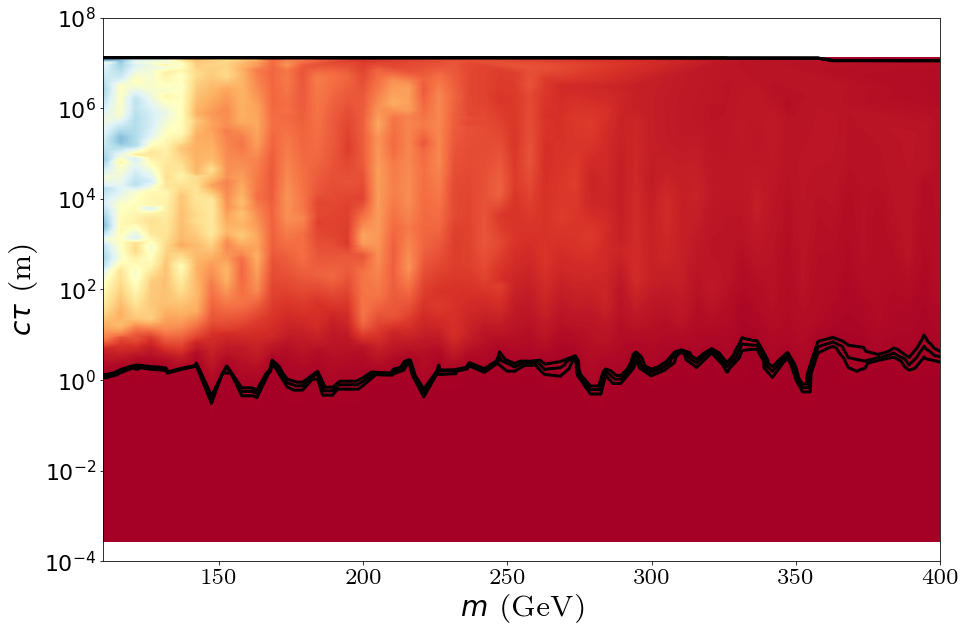

In [74]:
from scipy.interpolate import griddata
x,y,z = mHc,ctau,r

#Create a regular grid and interpolate using the original data:
newX = np.linspace(x.min(),x.max(),100)
newLogY = np.linspace(np.log10(y.min()),np.log10(y.max()),200)
newX, newLogY = np.meshgrid(newX,newLogY)

#Interpolate in log-scale:
oldLogPoints = np.array(list(zip(x,np.log10(y))))
newLogPoints = np.array([newX.flatten(),newLogY.flatten()]).T
newZ = griddata(oldLogPoints,z,newLogPoints,method='linear',fill_value=0.)

# Create the Triangulation; no triangles so Delaunay triangulation created.
newX = newLogPoints[:,0]
newY = np.power(10,newLogPoints[:,1])
triang = tri.Triangulation(newX,newY)
cp = plt.tricontourf(triang, newZ,cmap=cm, levels=np.arange(0.,120.,0.2))
cs = plt.tricontour(triang, newZ, colors='k',levels=[0.8,1.0,1.2])
# # plt.clabel(cs, cs.levels, inline=True, fontsize=25, fmt='%1.1f')
# # cb = plt.colorbar(cp)
plt.yscale('log')
plt.xlabel(r'$m$ (GeV)')    
plt.ylabel(r'$c\tau$ (m)')
# # cb.set_label(r'$r=\sigma_{th}/\sigma_{UL}$')
plt.ylim(1e-4,1e8)
plt.xlim(110.,400.)
# # # plt.savefig('gbPlot.pdf')
plt.show()


In [51]:
print(y.min(),y.max())
newY = np.geomspace(y.min(),y.max(),100)
print(newY[0],newY[-1])

0.00027294841177882714 13088900.718658505
0.00027294841177882725 13088900.718658512


In [85]:
sel = dataDF[(dataDF['mass.37'] > 520.) & (dataDF['ExptRes.result0.r'] > 1.)]
print(sel)

                               mass.35     mass.36     mass.37  width.35  \
filename                                                                   
20000000291_paramcard.slha  521.444133  524.545889  521.533764       0.0   

                                width.36      width.37  \
filename                                                 
20000000291_paramcard.slha  4.428998e-10  8.481600e-19   

                           ExptRes.result0.AnalysisID  \
filename                                                
20000000291_paramcard.slha         CMS-PAS-EXO-16-036   

                            ExptRes.result0.AnalysisSqrts (TeV)  \
filename                                                          
20000000291_paramcard.slha                                 13.0   

                           ExptRes.result0.DataSetID  \
filename                                               
20000000291_paramcard.slha                      c300   

                           ExptRes.result0.Mass (GeV)